# Spatial Access Metrics DEMO

Authors: [Irene Farah](https://www.linkedin.com/in/imfarah/),  [Julia Koschinsky](https://www.linkedin.com/in/julia-koschinsky-657599b1/), [Logan Noel](https://www.linkedin.com/in/lmnoel/).   
Contact: [Julia Koschinsky](mailto:jkoschinsky@uchicago.edu)  

Research assistance of [Shiv Agrawal](http://simonlab.uchicago.edu/people/ShivAgrawal.html), [Caitlyn Tien](https://www.linkedin.com/in/caitlyn-tien-0b784b161/) and [Richard Lu](https://www.linkedin.com/in/richard-lu-576874155/) is gratefully acknowledged.

Center for Spatial Data Science  
University of Chicago  

July 30, 2019

---

This notebook shows you how to calculate spatial access metrics that indicate how accessible points of origin are to destinations -- in this case, how spatially accessible home locations (centroids of Census tracts) are to health facilities like hospitals or health clinics. Using the travel time matrix from the p2p module, you can calculate the following spatial access metrics: 

**AccessModel**: an access score  
**AccessTime**: time to the closest destination  
**AccessCount**: count of nearby destinations within a travel time threshold  
**AccessSum**: sum of an attribute of destinations within a travel time threshold  
**DestSum**: sum of destinations within an area (also called container approach).  

Each model follows a similar procedure:

1. Define the model by providing the appropriate arguments 
2. Calculate the model  
3. Subset, aggregate, plot the results (optional)
4. Save the result as a csv or tmx file
 

Each of these steps are demonstrated below.

---

**_Standard Data Requirements_**  

* Each model requires two csv files as inputs: sources and destinations.   
* Destinations need to be constrained to the spatial extent of the origins.   
* Field names with symbols will be replaced by underscores in the csv file.

The standard variables required for all models are listed below:

* Source File
    * Unique index identifier (**ID**) (integer or real)  
    * **Latitude** and **longitude** coordinates (real)
    * To aggregate: **larger areal ID**
* Destination File
    * Unique index identifier (**ID**) (integer or real)
    * **Latitude** and **longitude** coordinates (real)
    * **Category** for each type of facility
    * To aggregate: **larger areal ID**
    
Additional variables are required for some models (specified above each model).

In [ ]:
cd ../..

In [ ]:
# Import modules
from spatial_access.p2p import *
from spatial_access.Models import *

In [4]:
# View sources and destinations for Chicago health facilities
import pandas as pd
sources_df = pd.read_csv('./data/input_data/sources/tracts2010.csv')
dests_df = pd.read_csv('./data/input_data/destinations/health_chicago.csv')

**Read in travel time matrix generated in [1_matrix.ipynb](./1_matrix.ipynb)**:

In [ ]:
matrix_df = pd.read_csv('./data/output_data/matrices/walk_asym_health_tracts.csv')

View the first 5 sources (tract centroids):

In [3]:
sources_df.head()

,geoid10,lon,lat,Pop2014,Pov14,community
0,17031842400,-87.630040,41.742475,5157,769,44
1,17031840300,-87.681882,41.832094,5881,1021,59
2,17031841100,-87.635098,41.851006,3363,2742,34
3,17031841200,-87.683342,41.855562,3710,1819,31
4,17031838200,-87.675079,41.870416,3296,361,28


View the first 5 destinations (health facilities):

In [4]:
dests_df.head()

,ID,Facility,lat,lon,Type,capacity,category,community
0,1,"American Indian Health Service of Chicago, Inc.",41.956676,-87.651879,5,127000,Other Health Providers,3
1,2,Hamdard Center for Health and Human Services,41.997852,-87.669535,5,190000,Other Health Providers,77
2,3,Infant Welfare Society of Chicago,41.924904,-87.717270,5,137000,Other Health Providers,22
3,4,Mercy Family - Henry Booth House Family Health...,41.841694,-87.624790,5,159000,Other Health Providers,35
4,6,Cook County - Dr. Jorge Prieto Health Center,41.847143,-87.724975,5,166000,Other Health Providers,30


View the first 5 records of the travel time matrix:

In [5]:
matrix_df.head()

,Unnamed: 0,1,2,3,4,6,8,9,10,11,...,198,199,200,201,202,203,204,205,206,Unnamed: 200
0,17031842400,17870,21397,17892,8483,13529,12425,5704,16935,7565,...,13236,16767,11419,14396,10325,12874,9266,8919,1718,NaN
1,17031840300,11391,13937,8845,4120,3713,3939,6358,8448,3721,...,4671,7050,3438,22725,1777,4898,3682,4482,8430,NaN
2,17031841100,9050,12577,9155,1374,5748,4035,5015,8198,2295,...,4799,8430,3042,21403,4769,4410,525,1494,9341,NaN
3,17031841200,9649,12195,7306,4588,3049,2017,8015,6846,5313,...,2958,5512,1672,24415,3590,3156,3484,4701,10378,NaN
4,17031838200,8222,10768,6219,5068,3794,590,8589,5440,5887,...,1552,4789,853,24887,5067,1729,3964,5181,10959,NaN


---

## Access Model: Access Score for Multiple Destinations


The Access Model generates an access score to measure how accessible a location is to multiple amenities within a given travel time (e.g. 20 minutes walking). You can specify three types of weights for this score: 

1) **distance decay** where closer amenities have more weight (default = linear)  
2) **relative importance of an amenity type** (e.g. with a greater weight for supermarkets than museums)  
3) **penalty for same types** (where more of the same type of amenity gets less weight). 

You can estimate the score with or without normalization.  
The AccessModel does not require population or target variables.


### Specifications for the Access Model:

**name = AccessModel( )**
* **network_type** ('walk', 'bike', 'drive', 'otp') 
* **sources_filename** (sources file)
* **destinations_filename** (destinations file)
* **source_column_names** (dictionary that contains column names (lat/lon/ID))
* **dest_column_names** (dictionary that contains column names (lat/lon/ID/category))
* **transit_matrix_filename** (sources-destination travel time matrix). If None, matrix estimated 'on the fly'.
* **decay_function** ('linear', 'root', 'logit', default is 'linear')

Note: Some access metrics do not need `population` or `capacity` columns but the prompt might still ask you for that column.  If the population or capacity column are not needed, write as 'skip' in source_column_names/dest_column_names.

**Column Inputs**
* Standard data requirements (see above)

**name.calculate()**
- **upper_threshold** (maximum number of seconds between origins and destinations)
- **category_weight_dict** (specifies the weight (importance) of each destination as a dictionary; default weights = [1,1,1,1,1,1,1,1,1,1])
- **normalize** (Boolean: default is False and shows non-normalized results; True shows normalized values.)
- **normalize_type** ('z_score' or 'minmax', default = 'minmax')

**Functions within the Access Model class** (use as name.function())
- calculate () 
- set.focus.categories()
- aggregate() 
- plot_cdf()
- plot_chloropleth ()

Each function is demonstrated below.

When specifying the Access Model, use the previously generated travel time matrix. Also specify the desired distance decay function. Here, source_column_names and dest_column_names are not specified so the model will ask you to map column names to expected values. 

---

Specify travel mode, file names, variable names and the distance decay function:

In [ ]:
accessM = AccessModel(network_type='walk',
                      sources_filename='./data/input_data/sources/tracts2010.csv',
                      destinations_filename='./data/input_data/destinations/health_chicago.csv',
                      transit_matrix_filename='./data/matrices/walk_asym_health_tracts.csv',
                      decay_function='linear')

Specify the weights for relative importance and same types:

In [68]:
dict = {
"Hospitals": [10,10,10,10,10],
"Federally Qualified Health Centers": [8, 7, 6, 5, 4],
"School-Based Health Centers": [7, 7, 6, 6, 5],
"All Free Health Clinics": [5, 5, 5, 4, 4],
"Other Health Providers": [4, 3, 2, 1, 1]
}

Specify the travel time threshold in seconds (e.g. 1,800 seconds = 30 minutes), whether or not to normalize the score, and the importance/variety weights:

In [ ]:
accessM.calculate(upper_threshold=1800,
                 category_weight_dict=dict,
                 normalize=False)

In [70]:
#Preview the results
accessM.model_results.head()

,all_categories_score,All Free Health Clinics_score,School-Based Health Centers_score,Federally Qualified Health Centers_score,Other Health Providers_score,Hospitals_score
17031842400,0.318889,0.000000,0.318889,0.000000,0.000000,0.000000
17031840300,6.784444,0.000000,0.089444,6.695000,0.000000,0.000000
17031841100,14.783889,0.072222,6.148333,1.884444,4.323333,2.355556
17031841200,29.545556,0.000000,7.127778,14.178889,0.000000,8.238889
17031838200,47.820000,1.008333,6.667222,8.044444,2.688889,29.411111


### **After constructing the Access Model**

#### **Once the access model is built, we can do several things:**
- Write out the data frame to a csv file
- Aggregate the results to a higher geographic level (in this example, from tracts to community areas)
- Subset data for specific categories of destinations (in this example, Federally Qualified Health Centers)
- Plot choropleth maps and cumulative distributive functions (CDF)

#### **Write Output to CSV**

Save the output as access_health_tracts_chicago.csv:

In [71]:
accessM.model_results.to_csv('./data/output_data/models/access_health_tracts_chicago.csv')

#### Visualize the data

Once the scores are in a csv, merge the scores to the origin's spatial file and map the scores to view the spatial distribution of the access scores. Here is example by tract:

<img src="./figures/Access_Model_all.png" width=500 title="Optional title"/>

#### **Aggregate to a Larger Geographic Scale**

The current results are displayed at the tract level. To view the results at a higher geographic level, we aggregate them at the community level. Then we write these results to a csv file. 

In [ ]:
#specify a shapefile and projection
accessM.aggregate(aggregation_type=None,
                  shapefile='./data/chicago_boundaries/chicago_boundaries.shp',
                  spatial_index='community',
                  projection='epsg:4326')

In [74]:
#Preview the output of the aggregated results by community area
accessM.aggregated_results.head()

,all_categories_score,All Free Health Clinics_score,School-Based Health Centers_score,Federally Qualified Health Centers_score,Other Health Providers_score,Hospitals_score
spatial_index,,,,,,
ALBANY PARK,15.033384,0.000000,6.700202,6.021566,0.000,2.311616
ARCHER HEIGHTS,6.844778,0.000000,0.000000,6.844778,0.000,0.000000
ARMOUR SQUARE,14.017778,0.014444,4.840333,3.961000,3.122,2.080000
ASHBURN,0.126389,0.000000,0.000000,0.000000,0.000,0.126389
AUBURN GRESHAM,5.466593,0.000000,2.484741,2.981852,0.000,0.000000


In [73]:
#For community areas: write to csv
accessM.write_aggregated_results(filename = "./data/output_data/models/accessModel_aggregated.csv")


#### Visualize the Aggregated Data

<img src="./figures/access_mod_agg.png" width="500" title="Optional title">

#### **Plot Aggregated Data**

The following cumulative distribution function shows the percentage of the population by access score.

INFO:spatial_access.BaseModel:Plot was saved to: data/output_data/accessModel_CDFplot


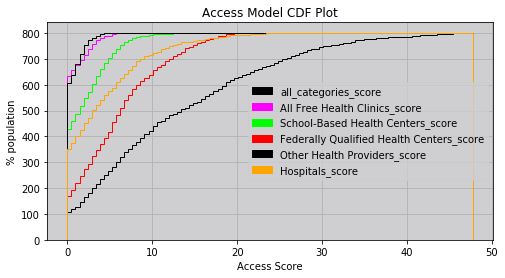

In [75]:
accessM.plot_cdf(filename = "./data/output_data/accessModel_CDFplot.png", 
                xlabel = "Access Score", ylabel = "% population", title = "Access Model CDF Plot")


The in-built charts are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/cdf_access_score.png" width="650" title="Optional title"  align="center">

In [ ]:
accessM.plot_choropleth(column = "all_categories_score",
                        title = "Access Model Scores in Chicago",
                        filename = "./data/output_data/accessModel_choropleth.png")


As with the plots above, in-built maps are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/map_AccessModel.png" width="650" title="Optional title"  align="center">

#### **Subset the Data to Calculate the Access Score for Specific Categories**

In [ ]:
#Subset for Federally Qualified Health Centers (walking)
accessM.set_focus_categories(['Federally Qualified Health Centers'])

In [66]:
#Example of importance and variety weights:
dict_FQ = {
"Federally Qualified Health Centers": [10,10,10,10,10]
}

In [ ]:
accessM.calculate(upper_threshold=1800,
                 normalize=True,
                 category_weight_dict=dict_FQ)
            

In [70]:
#Preview the results
accessM.model_results.head()

,all_categories_score,Federally Qualified Health Centers_score,Other Health Providers_score,School-Based Health Centers_score,All Free Health Clinics_score,Hospitals_score
17031842400,0.0,NaN,NaN,0.0,NaN,NaN
17031840300,0.0,NaN,NaN,0.0,NaN,NaN
17031841100,0.0,NaN,NaN,0.0,NaN,NaN
17031841200,0.0,NaN,NaN,0.0,NaN,NaN
17031838200,0.0,NaN,NaN,0.0,NaN,NaN


In [72]:
accessM.model_results.to_csv('./data/output_data/models/FQHC.csv')

## AccessTime: Time to the closest destination

AccessTime calculate the time it takes to reach the closest destination for each point of origin.  
AccessTime does not require population or target variables.

### Specifications for AccessTime

**name = AccessTime( )**
* **network_type** ('walk', 'bike', 'drive', 'otp') 
* **sources_filename** (primary input data)
* **destinations_filename** (secondary input data)
* **source_column_names** (dictionary that contains column names (lat/lon/ID))
* **dest_column_names** (dictionary that contains column names (lat/lon/ID/category))
* **transit_matrix_filename** (sources-destination travel time matrix). If None, matrix estimated 'on the fly'.

**Column Inputs**
* Standard data requirements (see above)

**name.calculate()**
* no specific input

**Functions within the AccessTime class** (use as name.function())  
- calculate () 
- aggregate() 
- set.focus.categories()
- plot_cdf()
- plot_choropleth


##### **Note**: 
For the following models, the examples specify source_column_names and dest_column_names upfront to avoid having to specify the expected values every time.

In [ ]:
accessT = AccessTime(network_type='walk',
                     transit_matrix_filename = './data/matrices/walk_asym_health_tracts.csv',
                     sources_filename='./data/input_data/sources/tracts2010.csv',
                     destinations_filename='./data/input_data/destinations/health_chicago.csv',
                     source_column_names={'idx' : 'geoid10', 'population': 'skip', 'lat': 'lat', 'lon': 'lon'},
                     dest_column_names={'idx': 'ID', 'capacity': 'skip', 'category': 'category', 'lat': 'lat', 'lon': 'lon'}
                    )


In [ ]:
#calculate Access Time
accessT.calculate()

In [80]:
#Preview the results
accessT.model_results.head()

,time_to_nearest_All Free Health Clinics,time_to_nearest_School-Based Health Centers,time_to_nearest_Federally Qualified Health Centers,time_to_nearest_Other Health Providers,time_to_nearest_Hospitals,time_to_nearest_all_categories
17031842400,3580,1718,2472,4831,3243,1718
17031840300,3289,1777,515,3329,2760,515
17031841100,1774,525,1376,174,1376,174
17031841200,2864,536,652,2017,1222,536
17031838200,1437,853,562,590,246,246


#### **Write Data Frame to CSV**

In [81]:
accessT.model_results.to_csv('./data/output_data/models/accessTime2010.csv')

#### **Aggregate Data to the Community Area Level**

In [ ]:
accessT.aggregate(aggregation_type = 'mean',
                  shapefile='./data/chicago_boundaries/chicago_boundaries.shp',
                  spatial_index='community',
                  projection='epsg:4326')


In [87]:
accessT.aggregated_results.head()

,time_to_nearest_All Free Health Clinics,time_to_nearest_School-Based Health Centers,time_to_nearest_Federally Qualified Health Centers,time_to_nearest_Other Health Providers,time_to_nearest_Hospitals,time_to_nearest_all_categories
spatial_index,,,,,,
ALBANY PARK,3160.909091,759.545455,1020.545455,3787.818182,1666.727273,734.272727
ARCHER HEIGHTS,4226.800000,2647.200000,886.800000,3563.200000,4692.200000,886.800000
ARMOUR SQUARE,2600.600000,1041.600000,1108.800000,826.600000,1509.200000,765.400000
ASHBURN,3996.875000,3354.375000,2955.875000,8258.750000,2287.000000,2236.375000
AUBURN GRESHAM,3638.533333,1179.400000,1132.466667,5745.866667,3260.133333,911.333333


In [88]:
#write aggregated to csv
accessT.write_aggregated_results(filename = 'data/output_data/models/accessTime_aggregated.csv')

#### **Plot Aggregated Data**

**CDF PLOT**

In [ ]:
accessT.plot_cdf(plot_type = 'time_to_nearest_all_categories',
                 title = 'Time to Nearest',
                 xlabel = 'time (s)',
                 ylabel = 'population',
                 filename = 'data/output_data/accessTime_CDFplot_allcat.png'
                )

The in-built charts are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/cdf_time.png" width="550" title="Optional title"  align="center">

**CHOROPLETH MAP**

INFO:spatial_access.BaseModel:Figure was saved to: data/output_data/accessTime_choropleth


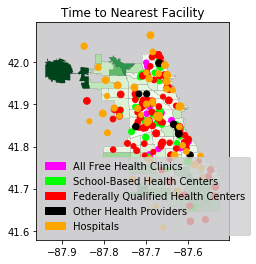

In [90]:
accessT.plot_choropleth(column = 'time_to_nearest_all_categories',
                        title = 'Time to Nearest Facility',
                        filename = './data/output_data/accessTime_choropleth.png)

As with the plots above, in-built maps are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/map_AccessTime.png" width="650" title="Optional title"  align="center">

#### **Subset Data for Categories of Destinations**
If you want to run the results for one or more provider type, you can subset the data by category.

In [91]:
#set focus category to FQHC; you set multiple focus categories, separated by commas 
accessT.set_focus_categories(['Federally Qualified Health Centers'])

In [ ]:
#calculate Access Time for focus categories
accessT.calculate()

In [93]:
#Preview results
accessT.model_results.head()

,time_to_nearest_Federally Qualified Health Centers,time_to_nearest_all_categories
17031842400,2472,2472
17031840300,515,515
17031841100,1376,1376
17031841200,652,652
17031838200,562,562


In [95]:
accessT.write_results(filename = './data/output_data/models/accessTime_subsetFQHC.csv')

## AccessCount: The number of destinations within a catchment area

Access Count measures the number of destinations within a given travel time (e.g. number of providers within 30 min walk of housing blocks). It does not require population or target variables.

### Specifications for AccessCount

**name = AccessCount( )**
* **network_type** ('walk', 'bike', 'drive', 'otp') 
* **sources_filename** (primary input data)
* **destinations_filename** (secondary input data)
* **source_column_names** (dictionary that contains column names (lat/lon/ID))
* **dest_column_names** (dictionary that contains column names (lat/lon/ID/category))
* **transit_matrix_filename** (sources-destination travel time matrix). If None, matrix estimated 'on the fly'.


**Column Inputs**
* Standard data requirements (see above)

**name.calculate()**
* upper_threshold (max time travel in seconds)

**Functions within the AccessTime class** (use as name.function())  
- calculate () 
- aggregate() 
- set.focus.categories()
- plot_cdf()
- plot_chlorepleth

In [ ]:
accessC = AccessCount(network_type='walk',
                      transit_matrix_filename='./data/matrices/walk_asym_health_tracts.csv',
                      sources_filename = './data/input_data/sources/tracts2010.csv',
                      destinations_filename='./data/input_data/destinations/health_chicago.csv',
                      source_column_names={'idx' : 'geoid10', 'population': 'skip', 'lat': 'lat', 'lon': 'lon'},
                      dest_column_names={'idx': 'ID', 'capacity': 'skip', 'category': 'category', 'lat': 'lat', 'lon': 'lon'}
                     )

In [ ]:
#walking threshold of 30 minutes
accessC.calculate(upper_threshold=1800)

In [98]:
#Preview the results
accessC.model_results.head()

,count_in_range_All Free Health Clinics,count_in_range_School-Based Health Centers,count_in_range_Federally Qualified Health Centers,count_in_range_Other Health Providers,count_in_range_Hospitals,count_in_range_all_categories
17031842400,0,1,0,0,0,1
17031840300,0,1,2,0,0,3
17031841100,1,2,1,2,1,7
17031841200,0,4,7,0,4,15
17031838200,1,4,4,1,6,16


In [99]:
#writes output to csv file
accessC.model_results.to_csv('./data/output_data/models/accessCount2010.csv')

#### **Aggregate Data to the Community Area Level**

In [ ]:
#Aggregate Access Count Data to the Chicago Community Area Level
accessC.aggregate()

In [101]:
#Preview results
accessC.aggregated_results.head()

,count_in_range_All Free Health Clinics,count_in_range_School-Based Health Centers,count_in_range_Federally Qualified Health Centers,count_in_range_Other Health Providers,count_in_range_Hospitals,count_in_range_all_categories
spatial_index,,,,,,
ALBANY PARK,0.0,1.818182,2.272727,0.0,0.909091,5.000000
ARCHER HEIGHTS,0.0,0.000000,2.600000,0.0,0.000000,2.600000
ARMOUR SQUARE,0.2,2.600000,1.600000,2.6,0.800000,7.800000
ASHBURN,0.0,0.000000,0.000000,0.0,0.125000,0.125000
AUBURN GRESHAM,0.0,0.866667,1.066667,0.0,0.000000,1.933333


In [102]:
#Write results to a csv file
accessC.write_aggregated_results(filename='./data/output_data/models/accessCount_aggregated.csv')

#### **Plot Aggregated Data**

INFO:spatial_access.BaseModel:Plot was saved to: data/output_data/accessCount_CDFplot


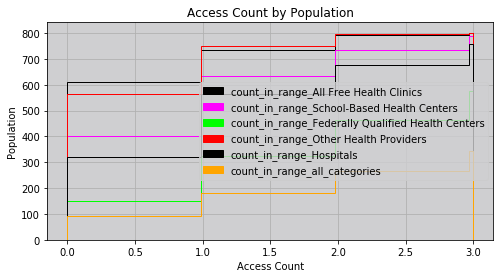

In [105]:
accessC.plot_cdf(filename = './data/output_data/accessCount_CDFplot.png',
                 xlabel = 'Access Count',
                 ylabel = 'Population',
                 title = 'Access Count by Population')

The in-built charts are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/cdf_count.png" width="550" title="Optional title"  align="center">

INFO:spatial_access.BaseModel:Figure was saved to: data/output_data/accessCount_choropleth


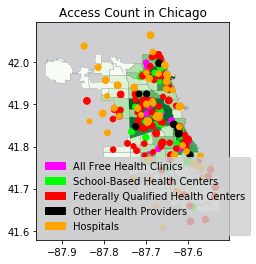

In [106]:
accessC.plot_choropleth(column='count_in_range_all_categories',
                        filename = './data/output_data/accessCount_choropleth.png',
                        title= 'Access Count in Chicago')

As with the plots above, in-built maps are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/map_AccessCount.png" width="650" title="Optional title"  align="center">

#### **Subset Data for Focus Categories**

In [107]:
#Limit category to FQHC
accessC.set_focus_categories(['Federally Qualified Health Centers'])

In [ ]:
#Calculate Access Time for FQHC
accessC.calculate(upper_threshold = 1800)

In [109]:
#Preview subsetted results
accessC.model_results.head()

,count_in_range_Federally Qualified Health Centers,count_in_range_all_categories
17031842400,0,0
17031840300,2,2
17031841100,1,1
17031841200,7,7
17031838200,4,4


In [110]:
#Write subsetted results to csv
accessC.write_results(filename = 'data/output_data/models/accessCount_subsetFQHC.csv')

## Access Sum: Captures the sum of an attribute within a catchment area

##### (e.g. number of doctors within a 30 min walk tracts' centroids)

Access Sum sums an attribute of a destination within a catchment area, e.g. the size of supermarkets within 30 minutes walking time from a point of origin.  It requires a target variable.

### Specifications for Access Sum
**name = AccessSum( )**
* **network_type** ('walk', 'bike', 'drive', 'otp') 
* **sources_filename** (primary input data)
* **destinations_filename** (secondary input data)
* **source_column_names** (dictionary that contains column names (lat/lon/ID))
* **dest_column_names** (dictionary that contains column names (lat/lon/ID/category))
* **transit_matrix_filename** (sources-destination travel time matrix). If None, matrix estimated 'on the fly'.

**Column Inputs**
* Standard data requirements (see above) plus **capacity** for each facility

**name.calculate()**
* upper_threshold (max time travel in seconds)

**Functions within the AccessSum class** (use as name.function())  
- calculate () 
- aggregate() 
- set.focus.categories()
- plot_cdf()
- plot_chlorepleth

---

Specify travel mode, file names and variable names:

In [ ]:
accessS = AccessSum(network_type='walk',
                     transit_matrix_filename='./data/matrices/walk_asym_health_tracts.csv',
                     sources_filename='./data/input_data/sources/tracts2010.csv',
                     destinations_filename='./data/input_data/destinations/health_chicago.csv',
                     source_column_names={'idx' : 'geoid10', 'population': 'skip', 'lat': 'lat', 'lon': 'lon'},
                     dest_column_names={'idx': 'ID', 'capacity': 'capacity', 'category': 'category', 'lat': 'lat', 'lon': 'lon'},
                     )

In [ ]:
#Calculate results
accessS.calculate(upper_threshold=1800)

In [113]:
#Preview results
accessS.model_results.head()

,sum_in_range_All Free Health Clinics,sum_in_range_School-Based Health Centers,sum_in_range_Federally Qualified Health Centers,sum_in_range_Other Health Providers,sum_in_range_Hospitals,sum_in_range_all_categories
17031842400,0,120000,0,0,0,120000
17031840300,0,163000,337000,0,0,500000
17031841100,143000,268000,193000,329000,131000,1064000
17031841200,0,654000,960000,0,548000,2162000
17031838200,196000,721000,543000,192000,960000,2612000


In [114]:
#Write model to csv
accessS.model_results.to_csv('./data/output_data/models/accessSum2010.csv')

#### **Aggregate Data to the Community Area Level**

In [ ]:
#Aggregate Access Sum data to the Chicago Community Area level
accessS.aggregate()

In [116]:
#Preview results
accessS.aggregated_results.head()

,sum_in_range_All Free Health Clinics,sum_in_range_School-Based Health Centers,sum_in_range_Federally Qualified Health Centers,sum_in_range_Other Health Providers,sum_in_range_Hospitals,sum_in_range_all_categories
spatial_index,,,,,,
ALBANY PARK,0.0,299090.909091,326181.818182,0.0,133181.818182,7.584545e+05
ARCHER HEIGHTS,0.0,0.000000,333000.000000,0.0,0.000000,3.330000e+05
ARMOUR SQUARE,28600.0,335400.000000,313600.000000,443800.0,104800.000000,1.226200e+06
ASHBURN,0.0,0.000000,0.000000,0.0,14875.000000,1.487500e+04
AUBURN GRESHAM,0.0,104000.000000,148200.000000,0.0,0.000000,2.522000e+05


In [117]:
#Write results to a csv file
accessS.write_aggregated_results(filename='./data/output_data/models/accessSum_aggregated.csv')

#### **Plot Aggregated Data**

INFO:spatial_access.BaseModel:Plot was saved to: data/output_data/accessSum_cdfplot


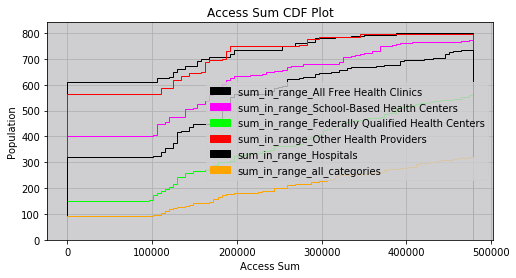

In [118]:
accessS.plot_cdf(filename= './data/output_data/accessSum_cdfplot.png',
                 title = 'Access Sum CDF Plot',
                 xlabel = 'Access Sum',
                 ylabel = 'Population')

The in-built charts are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/cdf_accesssum.png" width="550" title="Optional title"  align="center">

INFO:spatial_access.BaseModel:Figure was saved to: data/output_data/accessSum_choropleth


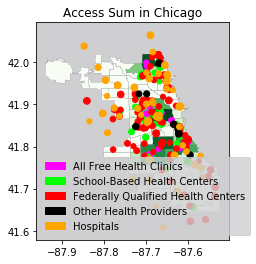

In [119]:
accessS.plot_choropleth(column= 'sum_in_range_All Free Health Clinics',
                        filename= 'data/output_data/accessSum_choropleth.png',
                        title = 'Access Sum in Chicago')

As with the plots above, in-built maps are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/map_AccessSum.png" width="650" title="Optional title"  align="center">

#### **Subset Data for Focus Categories**

In [120]:
#Limit catgeory to for FQHC
accessS.set_focus_categories(['Federally Qualified Health Centers'])

In [ ]:
#calculate subset data
accessS.calculate(upper_threshold = 1800)

In [122]:
#preview results
accessS.model_results.head()

,sum_in_range_Federally Qualified Health Centers,sum_in_range_all_categories
17031842400,0,0
17031840300,337000,337000
17031841100,193000,193000
17031841200,960000,960000
17031838200,543000,543000


In [123]:
#write subset results to csv
accessS.write_results(filename= './data/output_data/models/accessSum_subsetFQHC.csv')

## Destination Sum: The sum of a provider attribute within an area 

##### (e.g. number of doctors within a community area - does not require travel time matrix)

**Destination Sum** sums an attribute of a destination within a geographic boundary. It also generates this result per capita within these boundaries.  
This so-called container approach differs from Access Sum in that it sums point attributes within areas without relying on travel times. It requires population and target variables.

### Specifications for Destination Sum

**name = DestSum( )**
* **network_type** ('walk', 'bike', 'drive', 'otp') 
* **sources_filename** (primary input data)
* **destinations_filename** (secondary input data)
* **source_column_names** (dictionary that contains column names (lat/lon/ID))
* **dest_column_names** (dictionary that contains column names (lat/lon/ID/category))

**Column Inputs**
* Standard data requirements (see above) as well as the **capacity** for each facility

**name.calculate()**
* shapefile (shape file of an area; here default = Chicago community areas)
* spatial_index (index of geospatial area in shapefile; here default = community)
* projection (default = 'epsg:4326')

**Functions within the DestSum class** (use as name.function())  
- calculate ()  
- set.focus.categories()
- plot_cdf()
- plot_choropleth

In [124]:
d_sum = DestSum(network_type='walk',
                sources_filename='./data/input_data/sources/tracts2010.csv',
                destinations_filename='data/input_data/destinations/health_chicago.csv',
                source_column_names={'idx' : 'geoid10', 'population': 'skip', 'lat': 'lat', 'lon': 'lon'},
                dest_column_names={'idx': 'ID', 'capacity': 'capacity', 'category': 'category', 'lat': 'lat', 'lon': 'lon'}
               )

In [ ]:
# calculates DestSum for Chicago
d_sum.calculate()

In [127]:
#Preview the results
d_sum.aggregated_results.head()

,All Free Health Clinics,School-Based Health Centers,Federally Qualified Health Centers,Other Health Providers,Hospitals,all_categories,All Free Health Clinics_per_capita,School-Based Health Centers_per_capita,Federally Qualified Health Centers_per_capita,Other Health Providers_per_capita,Hospitals_per_capita,all_categories_per_capita
spatial_index,,,,,,,,,,,,
ALBANY PARK,0.0,329000.0,171000.0,0.0,0.0,500000.0,0.0,6.215757,3.230682,0.00000,0.000000,9.446439
ARCHER HEIGHTS,0.0,0.0,106000.0,0.0,0.0,106000.0,0.0,0.000000,7.572510,0.00000,0.000000,7.572510
ARMOUR SQUARE,0.0,0.0,0.0,170000.0,0.0,170000.0,0.0,0.000000,0.000000,17.72495,0.000000,17.724950
AUBURN GRESHAM,0.0,120000.0,141000.0,0.0,0.0,261000.0,0.0,2.520426,2.961500,0.00000,0.000000,5.481926
AUSTIN,0.0,190000.0,378000.0,0.0,125000.0,693000.0,0.0,1.849148,3.678832,0.00000,1.216545,6.744526


In [128]:
# writes result to csv
d_sum.write_aggregated_results('./data/output_data/models/destsum2010.csv')

In [ ]:
d_sum.set_focus_categories('Federally Qualified Health Centers')

In [ ]:
d_sum.head()